In [380]:
import sys
import time
import os
import gzip
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn
from torch_geometric.data import Data
from tqdm import tqdm
import networkx as nx
import torch_geometric

from io import BytesIO
from time import sleep 
from tqdm import tqdm

from config import (
    PATH_TO_FEATURES    
)

PATH_TO_LINKING_DATA = '../../datasets/string/'
PATH_TO_SAVE_DATA_TO = '../../datasets/string/my_datasets/'

PROTEIN_LINKS_FILE = '9606.protein.links.detailed.v11.5.txt.gz'
PROTEIN_INFO_FILE = '9606.protein.info.v11.5.txt.gz'

sns.set_theme(style="white")

## Protein links

In [3]:
# Read content of .gz file as bytes.
contents = gzip.open(f'{PATH_TO_LINKING_DATA}{PROTEIN_LINKS_FILE}', "rb").read()

# Convert bytes to pd.DataFrame.
data = BytesIO(contents)
protein_links_v1 = pd.read_csv(data, sep=' ')

print(protein_links_v1.shape)
protein_links_v1.head(5)

(11938498, 10)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,9606.ENSP00000000233,9606.ENSP00000379496,0,0,0,54,0,0,144,155
1,9606.ENSP00000000233,9606.ENSP00000314067,0,0,0,0,180,0,61,197
2,9606.ENSP00000000233,9606.ENSP00000263116,0,0,0,62,152,0,101,222
3,9606.ENSP00000000233,9606.ENSP00000361263,0,0,0,0,161,0,64,181
4,9606.ENSP00000000233,9606.ENSP00000409666,0,0,0,82,213,0,72,270


In [4]:
# Exclude the Homo Sapiens taxonomy ID from the protein columns.
protein_links_v2 = protein_links_v1.copy()
protein_links_v2.protein1 = protein_links_v2.protein1.str[5:]
protein_links_v2.protein2 = protein_links_v2.protein2.str[5:]
protein_links_v2.head(3)

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222


## Protein Info

In [5]:
# Read content of .gz file as bytes.
contents = gzip.open(f'{PATH_TO_LINKING_DATA}{PROTEIN_INFO_FILE}', "rb").read()

# Convert bytes to pd.DataFrame.
data = BytesIO(contents)
protein_info_v1 = pd.read_csv(data, sep='\t')

print(protein_info_v1.shape)
protein_info_v1.head(5)

(19566, 4)


,#string_protein_id,preferred_name,protein_size,annotation
0,9606.ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,9606.ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,9606.ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...
3,9606.ENSP00000001146,CYP26B1,512,Cytochrome P450 26B1; Involved in the metaboli...
4,9606.ENSP00000002125,NDUFAF7,441,"Protein arginine methyltransferase NDUFAF7, mi..."


In [6]:
# Rename protein identifier column.
protein_info_v2 = protein_info_v1.rename(columns={'#string_protein_id': 'string_protein_id'}, inplace=False)

# Exclude the Homo Sapiens taxonomy ID from the protein columns.
protein_info_v2.string_protein_id = protein_info_v2.string_protein_id.str[5:]
protein_info_v2.head(3)

,string_protein_id,preferred_name,protein_size,annotation
0,ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...


## Combine protein link and info

In [9]:
# ------------------------------------------------------------------------ #
# Map the corresponding genes to the proteins in the protein link dataset.
# ------------------------------------------------------------------------ #
# Get the gene symbols for the protein1 column.
protein_links_v3 = protein_links_v2.merge(right    = protein_info_v2[['string_protein_id', 'preferred_name']],
                                          how      = 'left',
                                          left_on  = 'protein1',
                                          right_on = 'string_protein_id')
protein_links_v3.rename(columns={'preferred_name': 'gene_symbol1'}, inplace=True)
protein_links_v3.drop(['string_protein_id'], axis=1, inplace=True)

# Get the gene symbols for the protein2 column.
protein_links_v4 = protein_links_v3.merge(right    = protein_info_v2[['string_protein_id', 'preferred_name']],
                                          how      = 'left',
                                          left_on  = 'protein2',
                                          right_on = 'string_protein_id')
protein_links_v4.rename(columns={'preferred_name': 'gene_symbol2'}, inplace=True)
protein_links_v4.drop(['string_protein_id'], axis=1, inplace=True)

print(f"""
    Shape:
        before joining : {protein_links_v2.shape}
        after  joining : {protein_links_v4.shape}
""")         
print(protein_links_v4[['gene_symbol1', 'gene_symbol2']].isna().sum())

# Unique number of genes per column.
uniq_gene1 = np.unique(protein_links_v4.gene_symbol1.values)
uniq_gene2 = np.unique(protein_links_v4.gene_symbol2.values)

print(f"""
    There are 
        {len(uniq_gene1)} unique gene_symbol1
        {len(uniq_gene2)} unique gene_symbol2
""")

protein_links_v4.head(5)


    Shape:
        before joining : (11938498, 10)
        after  joining : (11938498, 12)

gene_symbol1    0
gene_symbol2    0
dtype: int64

    There are 
        19382 unique gene_symbol1
        19382 unique gene_symbol2



,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155,ARF5,PDE1C
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197,ARF5,PAK2
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222,ARF5,RAB36
3,ENSP00000000233,ENSP00000361263,0,0,0,0,161,0,64,181,ARF5,RAPGEF1
4,ENSP00000000233,ENSP00000409666,0,0,0,82,213,0,72,270,ARF5,SUMO3


In [10]:
# Unique number of gene-gene combinations.
freq_per_tuple = protein_links_v4.groupby(['gene_symbol1', 'gene_symbol2']).size().reset_index(name='freq', inplace=False).sort_values(['freq'], ascending=False)
freq_per_tuple.groupby(['freq']).size().reset_index(name='count', inplace=False)

,freq,count
0,1,11936220
1,2,1139


- Some `(gene_symbol1, gene_symbol2)` tuples occur two times.
- However, the majority occurs only one time.

## Sparse dataset using overlapping genes

In [422]:
READ = True

if READ:
    start = time.time()
    with open(f'{PATH_TO_FEATURES}gexpr_sparse.pkl', 'rb') as f: 
        gexpr = pickle.load(f)
    with open(f'{PATH_TO_FEATURES}cnvg_sparse.pkl', 'rb') as f: 
        cnvg = pickle.load(f)
    with open(f'{PATH_TO_FEATURES}cnvp_sparse.pkl', 'rb') as f: 
        cnvp = pickle.load(f)
    with open(f'{PATH_TO_FEATURES}mut_sparse.pkl', 'rb') as f: 
        mut = pickle.load(f)  
    print(f"Took {time.time()-start:.5f} seconds to read the cell-line feature datasets.")
    print(f"""Shapes
    Gene Expression : {gexpr.shape}
    CNV Gistic      : {cnvg.shape}
    CNV Picnic      : {cnvp.shape}
    Mutation        : {mut.shape}
    """)

INTER_CLS = set(np.unique(gexpr.CELL_LINE_NAME.values).tolist()) \
    .intersection(set(np.unique(cnvg.CELL_LINE_NAME.values).tolist())) \
    .intersection(set(np.unique(cnvp.CELL_LINE_NAME.values).tolist())) \
    .intersection(set(np.unique(mut.CELL_LINE_NAME.values).tolist()))
    
assert len(INTER_CLS) == \
    len(np.unique(gexpr.CELL_LINE_NAME.values).tolist()) == \
    len(np.unique(cnvg.CELL_LINE_NAME.values).tolist()) == \
    len(np.unique(cnvp.CELL_LINE_NAME.values).tolist()) == \
    len(np.unique(mut.CELL_LINE_NAME.values).tolist()), \
        "Not all feature datasets contain the exact same cell lines as rows!"

INTER_GENES = set(np.unique(gexpr.columns[1:].values).tolist()) \
    .intersection(set(np.unique(cnvg.columns[1:].values).tolist())) \
    .intersection(set(np.unique(cnvp.columns[1:].values).tolist())) \
    .intersection(set(np.unique(mut.columns[1:].values).tolist()))

assert len(INTER_GENES) == \
    len(np.unique(gexpr.columns[1:].values).tolist()) == \
    len(np.unique(cnvg.columns[1:].values).tolist()) == \
    len(np.unique(cnvp.columns[1:].values).tolist()) == \
    len(np.unique(mut.columns[1:].values).tolist()), \
        "Not all feature datasets contain the exact same gene symbols as columns!"

print(f"Number of intersecting gene symbol columns: {len(INTER_GENES)}")    

Took 0.02138 seconds to read the cell-line feature datasets.
Shapes
    Gene Expression : (983, 859)
    CNV Gistic      : (983, 859)
    CNV Picnic      : (983, 859)
    Mutation        : (983, 859)
    
Number of intersecting gene symbol columns: 858


In [440]:
with open(f'{PATH_TO_FEATURES}intersecting_cls.pkl', 'wb') as f:
    pickle.dump(INTER_CLS, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{PATH_TO_FEATURES}intersecting_genes.pkl', 'wb') as f:
    pickle.dump(INTER_GENES, f, protocol=pickle.HIGHEST_PROTOCOL)

- Note that these gene symbol column are already only langmark genes

#### Assign indices

In [33]:
INTER_GENES_DF = pd.DataFrame({'GENE_SYMBOL': list(INTER_GENES)})
INTER_GENES_DF['GENE_INDEX'] = INTER_GENES_DF.index
INTER_GENES_DF.head(5)

,GENE_SYMBOL,GENE_INDEX
0,ARFIP2,0
1,CYTH1,1
2,HAT1,2
3,POLE2,3
4,PTPN1,4


- To each of these gene symbols we assigned a unique index
- This will be the key for the node in the graph

#### Only intersecting genes

In [23]:
protein_links_v5_sparsed = protein_links_v4.loc[(protein_links_v4.gene_symbol1.isin(INTER_GENES_DF.GENE_SYMBOL)) & 
                                                (protein_links_v4.gene_symbol2.isin(INTER_GENES_DF.GENE_SYMBOL))]
n_rows = protein_links_v5_sparsed.shape[0]
perc_kept = 100*n_rows/protein_links_v4.shape[0]
print(f"""After filtered down such that both columns ´gene_symbol1´ and ´gene_symbol2´ are landmark genes the shape is {n_rows} ({perc_kept:2.2f} %). 
This means {protein_links_v4.shape[0]-protein_links_v5_sparsed.shape[0]} have either one or both gene symbols not in the set of {INTER_GENES_DF.shape[0]} intersecting genes.
""")

After filtered down such that both columns ´gene_symbol1´ and ´gene_symbol2´ are landmark genes the shape is 83126 (0.70 %). 
This means 11855372 have either one or both gene symbols not in the set of 859 intersecting genes.



In [35]:
# Append corresponding index for each gene symbol column as new column(s).
protein_links_v6_indexed = protein_links_v5_sparsed.merge(
    right=INTER_GENES_DF,
    how='left',
    left_on=['gene_symbol1'],
    right_on=['GENE_SYMBOL'])
protein_links_v6_indexed.rename(columns={'GENE_INDEX': 'index_gene_symbol1'}, inplace=True)
protein_links_v6_indexed.drop(['GENE_SYMBOL'], axis=1, inplace=True)

protein_links_v7_indexed = protein_links_v6_indexed.merge(
    right=INTER_GENES_DF,
    how='left',
    left_on=['gene_symbol2'],
    right_on=['GENE_SYMBOL'])
protein_links_v7_indexed.rename(columns={'GENE_INDEX': 'index_gene_symbol2'}, inplace=True)
protein_links_v7_indexed.drop(['GENE_SYMBOL'], axis=1, inplace=True)

print(f"Shape: {protein_links_v7_indexed.shape}")
protein_links_v7_indexed.head(3) 

Shape: (83126, 14)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2,index_gene_symbol1,index_gene_symbol2
0,ENSP00000001008,ENSP00000408295,0,0,0,81,0,0,258,288,FKBP4,RFC5,324,827
1,ENSP00000001008,ENSP00000306245,0,0,0,0,59,0,177,192,FKBP4,FOS,324,688
2,ENSP00000001008,ENSP00000340989,0,0,0,0,78,0,123,157,FKBP4,SFN,324,39


In [36]:
new_col_order = [
    'protein1',
    'protein2',
    'gene_symbol1',
    'gene_symbol2',
    'index_gene_symbol1',
    'index_gene_symbol2',
    'neighborhood',
    'fusion',
    'cooccurence',
    'coexpression',
    'experimental',
    'database',
    'textmining',
    'combined_score'
]
protein_links_v7_indexed = protein_links_v7_indexed[new_col_order]
del new_col_order
protein_links_v7_indexed.head(5)

,protein1,protein2,gene_symbol1,gene_symbol2,index_gene_symbol1,index_gene_symbol2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,ENSP00000001008,ENSP00000408295,FKBP4,RFC5,324,827,0,0,0,81,0,0,258,288
1,ENSP00000001008,ENSP00000306245,FKBP4,FOS,324,688,0,0,0,0,59,0,177,192
2,ENSP00000001008,ENSP00000340989,FKBP4,SFN,324,39,0,0,0,0,78,0,123,157
3,ENSP00000001008,ENSP00000287156,FKBP4,UBE2L6,324,273,0,0,0,62,149,0,0,167
4,ENSP00000001008,ENSP00000217233,FKBP4,TRIB3,324,455,0,0,0,63,62,0,189,224


In [37]:
# Set of unique gene symbols.
nodes = np.unique(protein_links_v7_indexed[['gene_symbol1', 'gene_symbol2']].values)
print(f"There will be {len(nodes)} nodes in the graph.")

nodes_as_indices = np.unique(protein_links_v7_indexed[['index_gene_symbol1', 'index_gene_symbol2']].values)
print(f"There will be {len(nodes_as_indices)} indices in the graph.")

There will be 858 nodes in the graph.
There will be 858 indices in the graph.


In [41]:
# Create a list of tuples which hold neighbor nodes.
gene_symbol_tuples = list(set(list(zip(protein_links_v7_indexed.gene_symbol1, protein_links_v7_indexed.gene_symbol2))))
print(gene_symbol_tuples[:5])


# Map the list of tuples of neighbor gene nodes to the corresponding int. 
transform_gene_tuple_to_index_tuple = lambda x : (
    INTER_GENES_DF[INTER_GENES_DF['GENE_SYMBOL']==x[0]]['GENE_INDEX'].values[0], 
    INTER_GENES_DF[INTER_GENES_DF['GENE_SYMBOL']==x[1]]['GENE_INDEX'].values[0])
input_vec = [transform_gene_tuple_to_index_tuple(tup) for tup in gene_symbol_tuples]
print(input_vec[:5])

[('KDM5B', 'CD44'), ('TESK1', 'PPP2R5A'), ('AKAP8', 'RPS6KA1'), ('ZNF395', 'CASP3'), ('ACAT2', 'ALDH7A1')]
[(195, 198), (615, 540), (564, 411), (213, 201), (94, 89)]


In [181]:
neighbor_gene_tuples = copy.deepcopy(input_vec)
len(neighbor_gene_tuples)

83126

##### Create undirected neighbor tuple

Since we want to create an undirected graph, each tuple `(g1, g2)` needs to be also present as `(g2, g1)` in the list.

In [192]:
# Saving all tuples the other way around.
a_to_b = [[tup[0], tup[1]] for tup in neighbor_gene_tuples]
b_to_a = [[tup[1], tup[0]] for tup in neighbor_gene_tuples]

NEIGHBOR_GENES_UNDIRECTED = a_to_b + b_to_a
assert len(NEIGHBOR_GENES_UNDIRECTED) == 2*len(neighbor_gene_tuples), \
    "The undirected list of gene tuples needs to be exactly two times the directed one!"
print(len(NEIGHBOR_GENES_UNDIRECTED))
NEIGHBOR_GENES_UNDIRECTED[:5]

166252


[[195, 198], [615, 540], [564, 411], [213, 201], [94, 89]]

In [ ]:
for tup in NEIGHBOR_GENES_UNDIRECTED:
    assert [tup[1], tup[0]] in NEIGHBOR_GENES_UNDIRECTED, f"{tup} not undirected!"

##### Neighbors using the `GENE_SYMBOL`

In [42]:
# Find neighbors using the gene symbols.
dict_as_genes = {gene_node: [] for gene_node in nodes}  # or dict(zip(nodes, []*len(nodes)))

# Get the edges.
for gene in dict_as_genes:
    exists_in_gene_symbol1 = not protein_links_v7_indexed.loc[protein_links_v7_indexed.gene_symbol1==gene].empty
    exists_in_gene_symbol2 = not protein_links_v7_indexed.loc[protein_links_v7_indexed.gene_symbol2==gene].empty

    neighbor_nodes = None 
    if exists_in_gene_symbol1:
        neighbor_nodes = list(set(protein_links_v7_indexed.loc[protein_links_v7_indexed.gene_symbol1==gene].gene_symbol2))
    elif exists_in_gene_symbol2: 
        neighbor_nodes = list(set(protein_links_v7_indexed.loc[protein_links_v7_indexed.gene_symbol2==gene].gene_symbol1))
    else: 
        print(f"The gene {gene} couldn't be found in the dataset!") 

    # Set neighbors for the gene.
    dict_as_genes[gene] += [neighbor_node for neighbor_node in neighbor_nodes if neighbor_node not in dict_as_genes[gene]]

__Format__: 
- _key_: gene symbol
- _value_: list of gene symbols which are neighbors of the gene symbol of the key

##### Neighbors using the `GENE_INDEX`

In [43]:
# Find neighbors using the indices.
dict_as_indices = {gene_node: [] for gene_node in nodes_as_indices}  # or dict(zip(nodes, []*len(nodes)))

# Get the edges.
for gene in dict_as_indices:
    exists_in_gene_symbol1 = not protein_links_v7_indexed.loc[protein_links_v7_indexed.index_gene_symbol1==gene].empty
    exists_in_gene_symbol2 = not protein_links_v7_indexed.loc[protein_links_v7_indexed.index_gene_symbol2==gene].empty

    neighbor_nodes = None 
    if exists_in_gene_symbol1:
        neighbor_nodes = list(set(protein_links_v7_indexed.loc[protein_links_v7_indexed.index_gene_symbol1==gene].index_gene_symbol2))
    elif exists_in_gene_symbol2: 
        neighbor_nodes = list(set(protein_links_v7_indexed.loc[protein_links_v7_indexed.index_gene_symbol2==gene].index_gene_symbol1))
    else: 
        print(f"The gene {gene} couldn't be found in the dataset!") 

    # Set neighbors for the gene.
    dict_as_indices[gene] += [neighbor_node for neighbor_node in neighbor_nodes if neighbor_node not in dict_as_indices[gene]]

__Format__: 
- _key_: unique index of the gene symbol
- _value_: list of  gene symbol indices which are neighbors of the gene symbol index of the key

On average there are    97 neighbors per node.
Note that there are 858 keys/nodes/genes in total.
Thus, on average 11.29 % of all genes are neighbors.


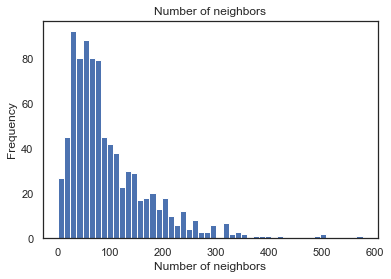

In [55]:
# How many neighbors are there on average?
len_of_neighbors = [len(neighbors) for _, neighbors in dict_as_indices.items()]
assert len(len_of_neighbors) == len(nodes)
print(f"On average there are {np.mean(len_of_neighbors):5.0f} neighbors per node.")
print(f"Note that there are {len(dict_as_indices.keys())} keys/nodes/genes in total.")
print(f"Thus, on average {100*np.mean(len_of_neighbors)/len(dict_as_indices.keys()):2.2f} %" +
    " of all genes are neighbors.")
plt.hist(len_of_neighbors, bins=50);
plt.title("Number of neighbors");
plt.xlabel("Number of neighbors");
plt.ylabel("Frequency");

In [57]:
dict_as_indices[0]

43

## Create PyTorch-Geometric format processed data

### For one cell-line

In [137]:
example_cl = '22RV1'
example_genes = list(gexpr[gexpr.CELL_LINE_NAME==example_cl].head(5).columns[1:])
example_genes[:10]

['FBXL12',
 'PIN1',
 'PAK4',
 'GNA15',
 'ARPP19',
 'EAPP',
 'MOK',
 'MTHFD2',
 'TIPARP',
 'CASP3']

In [138]:
gexpr_example = gexpr[gexpr.CELL_LINE_NAME==example_cl][['CELL_LINE_NAME'] + example_genes]
print(gexpr_example.values[0, 1:10])
gexpr_example

[7.02375908764879 6.06753445474259 4.31875040993261 3.26142732955643
 6.29758157647675 8.31399070206232 5.51491166262691 10.5941118116936
 5.22236633590822]


,CELL_LINE_NAME,FBXL12,PIN1,PAK4,GNA15,ARPP19,EAPP,MOK,MTHFD2,TIPARP,...,PDHX,DFFB,FOSL1,ETS1,EBNA1BP2,MYL9,MLLT11,PFKL,FGFR4,SDHB
0,22RV1,7.023759,6.067534,4.31875,3.261427,6.297582,8.313991,5.514912,10.594112,5.222366,...,7.821536,3.601622,3.225596,3.651201,7.895763,3.953414,4.059382,4.376822,3.215209,9.267565


In [139]:
cnvg_example = cnvg[cnvg.CELL_LINE_NAME==example_cl][['CELL_LINE_NAME'] + example_genes]
print(cnvg_example.values[0, 1:10])
cnvg_example

[0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 1.0]


,CELL_LINE_NAME,FBXL12,PIN1,PAK4,GNA15,ARPP19,EAPP,MOK,MTHFD2,TIPARP,...,PDHX,DFFB,FOSL1,ETS1,EBNA1BP2,MYL9,MLLT11,PFKL,FGFR4,SDHB
0,22RV1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,...,-1.0,-1.0,0.0,0.0,0.0,0.0,1.0,-1.0,-1.0,-1.0


In [140]:
cnvp_example = cnvp[cnvp.CELL_LINE_NAME==example_cl][['CELL_LINE_NAME'] + example_genes]
print(cnvp_example.values[0, 1:10])
cnvp_example

[2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0]


,CELL_LINE_NAME,FBXL12,PIN1,PAK4,GNA15,ARPP19,EAPP,MOK,MTHFD2,TIPARP,...,PDHX,DFFB,FOSL1,ETS1,EBNA1BP2,MYL9,MLLT11,PFKL,FGFR4,SDHB
0,22RV1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0


In [375]:
cnvp2 = copy.deepcopy(cnvp)
cnvp2.set_index('CELL_LINE_NAME', inplace=True)
cnvp2.head(5)

,FBXL12,PIN1,PAK4,GNA15,ARPP19,EAPP,MOK,MTHFD2,TIPARP,CASP3,...,PDHX,DFFB,FOSL1,ETS1,EBNA1BP2,MYL9,MLLT11,PFKL,FGFR4,SDHB
CELL_LINE_NAME,,,,,,,,,,,,,,,,,,,,,
22RV1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0
23132-87,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0
42-MG-BA,4.0,4.0,4.0,4.0,5.0,6.0,5.0,3.0,3.0,3.0,...,3.0,5.0,5.0,5.0,5.0,6.0,3.0,5.0,5.0,4.0
451Lu,4.0,4.0,4.0,4.0,4.0,3.0,3.0,4.0,4.0,3.0,...,3.0,5.0,3.0,3.0,5.0,6.0,4.0,4.0,4.0,5.0
5637,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,4.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,4.0,3.0


In [376]:
cnvp2.loc['23132-87']

FBXL12    2.0
PIN1      2.0
PAK4      2.0
GNA15     2.0
ARPP19    2.0
         ... 
MYL9      3.0
MLLT11    3.0
PFKL      2.0
FGFR4     2.0
SDHB      2.0
Name: 23132-87, Length: 858, dtype: float64

In [378]:
torch.tensor(cnvp[cnvp.CELL_LINE_NAME==example_cl][example_genes].values[0, :])

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 2., 2., 3., 2.,
        2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 3., 3., 3., 2.,
        2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 3.,
        2., 2., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 2.,
        2., 2., 2., 2., 2., 2., 3., 2., 

In [141]:
mut_example = mut[mut.CELL_LINE_NAME==example_cl][['CELL_LINE_NAME'] + example_genes]
print(mut_example.values[0, 1:10])
mut_example

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]


gene_symbol,CELL_LINE_NAME,FBXL12,PIN1,PAK4,GNA15,ARPP19,EAPP,MOK,MTHFD2,TIPARP,...,PDHX,DFFB,FOSL1,ETS1,EBNA1BP2,MYL9,MLLT11,PFKL,FGFR4,SDHB
0,22RV1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [142]:
# Two ways of converting
print(torch.from_numpy(np.array(mut_example.values[0, 1:10], dtype=np.float64)))
print(torch.tensor(np.array(mut_example.values[0, 1:10], dtype=np.float64), dtype=torch.float64))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=torch.float64)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=torch.float64)


In [143]:
gexpr_tens = torch.tensor(np.array(gexpr_example.values[0, 1:], dtype=np.float64), dtype=torch.float64)
cnvg_tens = torch.tensor(np.array(cnvg_example.values[0, 1:], dtype=np.float64), dtype=torch.float64)
cnvp_tens = torch.tensor(np.array(cnvp_example.values[0, 1:], dtype=np.float64), dtype=torch.float64)
mut_tens = torch.tensor(np.array(mut_example.values[0, 1:], dtype=np.float64), dtype=torch.float64)

In [159]:
example_stacked = torch.stack([gexpr_tens, cnvg_tens, cnvp_tens, mut_tens])
print(example_stacked.shape)
example_stacked

torch.Size([4, 858])


tensor([[ 7.0238,  6.0675,  4.3188,  ...,  4.3768,  3.2152,  9.2676],
        [ 0.0000,  0.0000,  0.0000,  ..., -1.0000, -1.0000, -1.0000],
        [ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0000,  0.0000]],
       dtype=torch.float64)

In [160]:
# Swap dimension
example_stacked_swap = example_stacked.permute(1,0)
print(example_stacked_swap.shape)
example_stacked_swap

torch.Size([858, 4])


tensor([[ 7.0238,  0.0000,  2.0000,  0.0000],
        [ 6.0675,  0.0000,  2.0000,  0.0000],
        [ 4.3188,  0.0000,  2.0000,  0.0000],
        ...,
        [ 4.3768, -1.0000,  2.0000,  0.0000],
        [ 3.2152, -1.0000,  2.0000,  1.0000],
        [ 9.2676, -1.0000,  2.0000,  0.0000]], dtype=torch.float64)

- 1st index = gene expression
- 2nd index = copy number gistic
- 3rd index = copy number picnic
- 4th index = mutation

In [441]:
import torch 
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, is_undirected

edge_index = torch.tensor(NEIGHBOR_GENES_UNDIRECTED, dtype=torch.long).t().contiguous() # All neighbor tuples.
x = example_stacked_swap.clone().detach() # Per index (node/gene) the features. 

example_graph = Data(x=x, 
                    edge_index=to_undirected(edge_index))

print(is_undirected(example_graph.edge_index))      
print(example_graph.is_undirected()) 
example_graph

True
False


Data(x=[858, 4], edge_index=[2, 83126])

In [357]:
example_graph.edge_index

tensor([[  0,   0,   0,  ..., 858, 858, 858],
        [  1,  71,  83,  ..., 829, 831, 856]])

- `x`: 4 nodes features per each of the 858 gene nodes.
- `edge_index`: 83,126 links in the graph, where the `i`'s entry of the 1st row is connected to the `i`'s entry of the 2nd row

In [356]:
print(f"""
    data.num_nodes          : {example_graph.num_nodes}
    data.num_edges          : {example_graph.num_edges}
    data.num_node_features  : {example_graph.num_node_features}
    data.num_edge_features  : {example_graph.num_edge_features}
    data.has_isolated_nodes : {example_graph.has_isolated_nodes()}
    data.has_self_loops     : {example_graph.has_self_loops()}
    data.is_directed        : {example_graph.is_directed()}
    data.is_undirected      : {example_graph.is_undirected()}
""")


    data.num_nodes          : 858
    data.num_edges          : 83126
    data.num_node_features  : 4
    data.num_edge_features  : 0
    data.has_isolated_nodes : False
    data.has_self_loops     : False
    data.is_directed        : True
    data.is_undirected      : False



In [245]:
# TODO: Why is it not undirected??? Why is edge_index directed, but the entire graph is undirected?

### For every cell-line

Note that since the topology of each graph per cell-line will be identical, only the feature values are changing.

```python
    Data(
        x           # changing for each cell-line.
        edge_index  # doesn't change for each cell-line.
    )
```

In [424]:
gexpr.set_index('CELL_LINE_NAME', inplace=True)
cnvg.set_index('CELL_LINE_NAME', inplace=True)
cnvp.set_index('CELL_LINE_NAME', inplace=True)
mut.set_index('CELL_LINE_NAME', inplace=True)

In [452]:
GENES = list(INTER_GENES)
Gs = {}
for cl in tqdm(list(INTER_CLS)):
    # Convert the feature values to tensors and stack them up.
    gexpr_cl = torch.tensor(gexpr.loc[cl][GENES].values, dtype=torch.float64)
    cnvg_cl = torch.tensor(cnvg.loc[cl][GENES].values, dtype=torch.float64)
    cnvp_cl = torch.tensor(cnvp.loc[cl][GENES].values, dtype=torch.float64)
    mut_cl = torch.tensor(mut.loc[cl][GENES].values, dtype=torch.float64)

    features = torch.stack([gexpr_cl, cnvg_cl, cnvp_cl, mut_cl]).t()

    # Generate the graph.
    edge_index = torch.tensor(NEIGHBOR_GENES_UNDIRECTED, dtype=torch.long).t().contiguous()
    G_cl = Data(x=features, edge_index=to_undirected(edge_index))

    Gs[cl] = G_cl


100%|██████████| 983/983 [01:22<00:00, 11.97it/s]


In [453]:
print(len(list(Gs.keys())))
print(Gs['22RV1']) # Example cell line
print(Gs['22RV1'].x)

983
Data(x=[858, 4], edge_index=[2, 83126])
tensor([[ 6.7396,  0.0000,  2.0000,  0.0000],
        [ 4.3421, -1.0000,  2.0000,  1.0000],
        [ 8.6186, -2.0000,  1.0000,  0.0000],
        ...,
        [ 9.2071,  0.0000,  2.0000,  0.0000],
        [ 3.8831,  0.0000,  2.0000,  1.0000],
        [ 6.0683,  1.0000,  3.0000,  1.0000]], dtype=torch.float64)


In [454]:
with open(f'{PATH_TO_FEATURES}cl_graphs_as_dict.pkl', 'wb') as f:
    pickle.dump(Gs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [455]:
READ = False 

if READ: 
    with open(f'{PATH_TO_FEATURES}cl_graphs_as_dict.pkl', 'rb') as f:
        Gs = pickle.load(f)

##### Summary of final dataset

The final dataset is now a dictionary with 983 keys which are the cell-lines and 983 graphs as values per cell-line. Each of these graphs has the exact same topology
```python 
  Data(x=[858, 4], edge_index=[2, 83126])
```
which means there are 
- 858 genes as nodes
- 4 node features
  1. gene expression 
  2. copy number gistic 
  3. copy number picnic 
  4. gene mutation 
- 83,126 connections/links
  - the 2 stands for two lists where always the `i`'s gene of the 1st list is connected to the `i`'s gene of the 2nd list